In [ ]:
!pip install nbimporter

In [57]:
import numpy as np
import pandas as pd
import nbimporter 
import matrix_factorization
np.random.seed(0)

In [ ]:
# Downloading Movielens-100k
!curl -O http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip ml-100k.zip
!cd ml-100k/

In [ ]:
import zipfile
with zipfile.ZipFile('ml-100k.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [58]:
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('./ml-100k/u.data', sep='\t', names=names)
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [59]:
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]
ratings

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [60]:
ratings.shape

(943, 1682)

In [61]:
def get_sparsity(mat):
    print (str(n_users) + ' users')
    print (str(n_items) + ' items')
    sparsity = float(len(mat.nonzero()[0]))
    sparsity /= (mat.shape[0] * mat.shape[1])
    sparsity *= 100
    return sparsity

In [62]:
print ('Sparsity: {:4.2f}%'.format(get_sparsity(ratings)))

943 users
1682 items
Sparsity: 6.30%


In [63]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], size=10, replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [64]:
train, test = train_test_split(ratings)

In [65]:
MF_SGD = matrix_factorization.ExplicitMF(train, 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

iter_array = [10]
MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=0.001)

Iteration: 10
	current iteration: 10
Train mse: 0.9179628673300955
Test mse: 1.0113053267188021


##################################################################################################################

In [66]:
train.shape

(943, 1682)

In [67]:
test.shape

(943, 1682)

In [68]:
ratings

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [69]:
get_sparsity(ratings)

943 users
1682 items


6.304669364224531

In [70]:
get_sparsity(train)

943 users
1682 items


5.710139043178159

In [71]:
get_sparsity(test)

943 users
1682 items


0.5945303210463734

# ####################################### GANS ###################################################

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils import data as t_data
import torchvision.datasets as datasets
from torchvision import transforms

In [73]:
batch_size = 5

In [74]:
def make_some_noise(batch_size):
    return torch.rand(batch_size,100)

In [75]:
make_some_noise(batch_size)

tensor([[0.4625, 0.8899, 0.1385, 0.0472, 0.5384, 0.6960, 0.9908, 0.9145, 0.5137,
         0.6804, 0.8615, 0.4312, 0.6037, 0.9117, 0.4875, 0.6603, 0.7794, 0.3952,
         0.4483, 0.1756, 0.2478, 0.1236, 0.5203, 0.9911, 0.0862, 0.7621, 0.7322,
         0.2437, 0.9434, 0.2282, 0.7428, 0.1790, 0.4105, 0.3193, 0.7175, 0.1299,
         0.0746, 0.1848, 0.7205, 0.9461, 0.6725, 0.6661, 0.1551, 0.5163, 0.9645,
         0.6228, 0.6040, 0.0699, 0.2416, 0.7396, 0.7768, 0.7044, 0.6805, 0.9212,
         0.3998, 0.4781, 0.7919, 0.1231, 0.0625, 0.3906, 0.3922, 0.2182, 0.4140,
         0.5691, 0.3555, 0.2843, 0.9089, 0.5347, 0.3190, 0.8424, 0.1724, 0.9083,
         0.5839, 0.5719, 0.1140, 0.8031, 0.0887, 0.0116, 0.7744, 0.4654, 0.6525,
         0.8710, 0.9873, 0.5563, 0.8061, 0.2056, 0.1669, 0.8843, 0.9240, 0.0941,
         0.0692, 0.3054, 0.9895, 0.8850, 0.4217, 0.8719, 0.8767, 0.7187, 0.7997,
         0.0846],
        [0.7759, 0.3813, 0.0787, 0.3424, 0.7061, 0.4004, 0.9523, 0.9829, 0.7490,
         0

In [76]:
# defining generator class

class generator(nn.Module):
    
    def __init__(self, inp, out):
        
        super(generator, self).__init__()
        
        self.net = nn.Sequential(
                                 nn.Linear(inp,300),
                                 nn.Tanh(),
                                 nn.Linear(300,1000),
                                 nn.Tanh(),
                                 nn.Linear(1000,800),
                                 nn.Tanh(),
                                 nn.Linear(800,out),
                                 nn.Sigmoid()
                                    )
        
    def forward(self, x):
        x = self.net(x)
        return x*5 # to get values in range [0,5]

In [77]:
# defining discriminator class

class discriminator(nn.Module):
    
    def __init__(self, inp, out):
        
        super(discriminator, self).__init__()
        
        self.net = nn.Sequential(
                                 nn.Linear(inp,300),
                                 nn.Tanh(),
                                 nn.Linear(300,300),
                                 nn.Tanh(),
                                 nn.Linear(300,200),
                                 nn.Tanh(),
                                 nn.Linear(200,out),
                                 nn.Sigmoid()
                                    )
        
    def forward(self, x):
        x = self.net(x)
        return x

In [78]:
dis = discriminator(ratings.shape[1], 1)
gen = generator(100, ratings.shape[1])

In [79]:
dis

discriminator(
  (net): Sequential(
    (0): Linear(in_features=1682, out_features=300, bias=True)
    (1): Tanh()
    (2): Linear(in_features=300, out_features=300, bias=True)
    (3): Tanh()
    (4): Linear(in_features=300, out_features=200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=200, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [80]:
gen

generator(
  (net): Sequential(
    (0): Linear(in_features=100, out_features=300, bias=True)
    (1): Tanh()
    (2): Linear(in_features=300, out_features=1000, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1000, out_features=800, bias=True)
    (5): Tanh()
    (6): Linear(in_features=800, out_features=1682, bias=True)
    (7): Sigmoid()
  )
)

In [81]:
d_steps = 300
g_steps = 300

criteriond1 = nn.BCELoss()
optimizerd1 = optim.SGD(dis.parameters(), lr=0.0001, momentum=0.9)

criteriond2 = nn.BCELoss()
optimizerd2 = optim.SGD(gen.parameters(), lr=0.0001, momentum=0.9)

# printing_steps = 200

epochs = 50

In [82]:
def get_random_batch(mat, batch_size=16):
    rand_rows = np.random.randint(mat.shape[0], size=batch_size)
#     print(mat.shape, rand_rows)
#     print(mat[rand_rows].shape)
    return mat[rand_rows]
    
get_random_batch(train)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [83]:
train = torch.autograd.Variable(torch.Tensor(train))

In [84]:
import torch.nn.functional as F
eval_losses = []
for epoch in range(10):
#     print (epoch)

    # training discriminator
    gen.train()
    dis.train()
    for d_step in range(d_steps):
        dis.zero_grad()
        
        # training discriminator on real data
        real_rows = get_random_batch(train, batch_size)
        discriminator_real_outputs = dis(real_rows)
   
        dis_real_loss = criteriond1(discriminator_real_outputs, Variable(torch.ones(batch_size,1)))
    
        dis_real_loss.backward()

        # training discriminator on data produced by generator
        z_vector = make_some_noise(batch_size)
        #output from generator is generated        
        fake_rows = gen(z_vector).detach()
#         print(fake_rows[:20])
        dis_fake_out = dis(fake_rows)
        dis_fake_loss = criteriond1(dis_fake_out, Variable(torch.zeros(batch_size,1)))
        dis_fake_loss.backward()

        optimizerd1.step()
        
    # training generator
    for g_step in range(g_steps):
        gen.zero_grad()
        
        #generating data for input for generator
        z_vector = make_some_noise(batch_size)
        
        fake_rows = gen(z_vector)
#         print(fake_rows.shape, z_vector.shape)
#         print(fake_rows[:20])
        dis_out_gen_training = dis(fake_rows)
        gen_loss = criteriond2(dis_out_gen_training, Variable(torch.ones(batch_size,1)))
        gen_loss.backward()
        
        optimizerd2.step()

    # evaluation
    if epoch % 10: # todo- to change
        gen.eval()
        z_vector_eval = make_some_noise(128)
        fake_rows_eval = gen(z_vector_eval)
        real_rows_eval = get_random_batch(train, 128)
#         print(fake_rows[0][:10]) enable to see some results
        eval_loss = F.mse_loss(fake_rows_eval, real_rows_eval, reduction='sum')
        eval_losses.append(eval_loss)
        print('Epoch number {}. MSE distance between random real and fake samples {}'.format(epoch, eval_loss))
#         print('Epoch number {}. L1 distance between random real and fake samples {}'.format(epoch, torch.sum(torch.abs(fake_rows_eval - real_rows_eval))))
        

Epoch number 1. MSE distance between random real and fake samples 1298359.125
Epoch number 2. MSE distance between random real and fake samples 1268023.75
Epoch number 3. MSE distance between random real and fake samples 1268135.5
Epoch number 4. MSE distance between random real and fake samples 1233828.5
Epoch number 5. MSE distance between random real and fake samples 1125817.75
Epoch number 6. MSE distance between random real and fake samples 995061.8125
Epoch number 7. MSE distance between random real and fake samples 831373.25
Epoch number 8. MSE distance between random real and fake samples 670957.875
Epoch number 9. MSE distance between random real and fake samples 550445.125


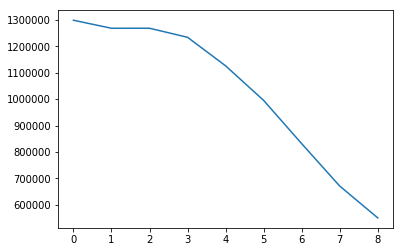

In [85]:
import matplotlib.pyplot as plt

plt.plot(eval_losses)
plt.show()

In [86]:
z_vector = make_some_noise(16)
fake_rows = gen(z_vector)

In [87]:
# as we see generator produces very similar vectors 
fake_rows[:,:9]

tensor([[4.9296, 1.1387, 1.5669, 4.4206, 0.4383, 0.2694, 4.9433, 4.7220, 4.8977],
        [4.9277, 1.1527, 1.5739, 4.4191, 0.4444, 0.2746, 4.9425, 4.7164, 4.8955],
        [4.9312, 1.1420, 1.5630, 4.4317, 0.4344, 0.2639, 4.9453, 4.7252, 4.8993],
        [4.9308, 1.1444, 1.5674, 4.4309, 0.4359, 0.2632, 4.9453, 4.7279, 4.9002],
        [4.9317, 1.1397, 1.5696, 4.4296, 0.4315, 0.2638, 4.9450, 4.7237, 4.8992],
        [4.9310, 1.1437, 1.5655, 4.4315, 0.4401, 0.2631, 4.9450, 4.7255, 4.8991],
        [4.9325, 1.1276, 1.5595, 4.4367, 0.4300, 0.2606, 4.9464, 4.7292, 4.9007],
        [4.9297, 1.1481, 1.5686, 4.4245, 0.4381, 0.2660, 4.9439, 4.7202, 4.8971],
        [4.9299, 1.1483, 1.5665, 4.4282, 0.4392, 0.2659, 4.9437, 4.7233, 4.8975],
        [4.9301, 1.1490, 1.5645, 4.4264, 0.4349, 0.2656, 4.9448, 4.7249, 4.8983],
        [4.9315, 1.1431, 1.5661, 4.4319, 0.4339, 0.2620, 4.9456, 4.7275, 4.8996],
        [4.9292, 1.1445, 1.5628, 4.4257, 0.4406, 0.2674, 4.9435, 4.7210, 4.8979],
        [4.9312,

In [88]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import torch.nn.init as init
from os.path import isfile, isdir, join
import os
# from tensorboard_logger import configure, log_value

In [89]:
# lrD = 5e-4
# lrG = 5e-4
# batch_size = 100
# cuda = True
# epochs = 1000
# device = 5
# seed = 42
# nz = 100
# d_iter = 5
# g_iter = 1
# lamba = 1e-2 # constant for L2 penalty (diversity)
# name = "mnist-experiment"
# # configure("runs/run-" + args.name, flush_secs=5)
# torch.manual_seed(seed)
# # if cuda:
# # #     torch.cuda.set_device('cuda')
# #     torch.cuda.manual_seed(seed)
# # data_loader = torch.utils.data.DataLoader(
# # datasets.MNIST('../data', train=True, download=True,
# # transform=transforms.Compose([transforms.ToTensor(),])), batch_size=batch_size, shuffle=True)

In [90]:
lrD = 5e-4
lrG = 5e-4
batch_size = 100
cuda = True
epochs = 1000
device = 5
seed = 1
nz = 10
d_iter = 5
g_iter = 1
lamba = 1e-2 # constant for L2 penalty (diversity)
name = "mnist-experiment"
# configure("runs/run-" + args.name, flush_secs=5)
torch.manual_seed(seed)


data_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
    transforms.ToTensor(),
    ])), batch_size=batch_size, shuffle=True)

In [91]:
# length=6
# batch_size=5

In [103]:
class NetD(torch.nn.Module):
    def __init__(self, use_cuda=True):
        super(NetD, self).__init__()
        self.use_cuda = use_cuda
        # top
        self.t1 = torch.nn.Linear(28 * 28, 1024)
        # bottom
        self.b1 = torch.nn.Linear(28 * 28, 1024)
        # combined
        self.fc = torch.nn.Linear(2 * 1024, 28 * 28)
    def forward(self, xr, xf):
        # get filt
        filt = 1 - (xr * (xf >= 0.5).float()) - ((1-xr) * (xf < 0.5).float())
        # random swap
        idr = torch.multinomial(torch.Tensor([0.5,0.5]), xr.size(0), replacement=True)
        idrx = idr.float().unsqueeze(1).expand_as(xr)
        if self.use_cuda: 
            idrx = idrx.cuda()
        idrx = Variable(idrx)
        xt = xr * idrx + xf * (1 - idrx)
        xb = xr * (1 - idrx) + xf * idrx
        # top : real
        xt = F.relu(self.t1(xt))
        # bottom : fake
        xb = F.relu(self.b1(xb))
        # combined
        x = torch.cat((xt, xb), 1)
        x = torch.tanh(self.fc(x))
        # apply filter, aggregate
        x = filt * x
        x = x.mean(dim = 1).squeeze()
        # use sign, because of swapping
        sgn = idr * 2 - 1
        if self.use_cuda: 
            sgn = sgn.cuda()
        sgn = Variable(sgn.float())
        x = sgn * x
        return x
        
netG = torch.nn.Sequential(
    torch.nn.Linear(nz, 1024),
    torch.nn.ReLU(),
    torch.nn.Linear(1024, 28 * 28),
    torch.nn.Sigmoid()
    )

# networks
netD = NetD(use_cuda=False)
print(netG)
print(netD)
optimizerG = optim.RMSprop(netG.parameters(), lr=lrG)
optimizerD = optim.RMSprop(netD.parameters(), lr=lrD)
one = torch.FloatTensor([1])
mone = one * -1

Sequential(
  (0): Linear(in_features=10, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=784, bias=True)
  (3): Sigmoid()
)
NetD(
  (t1): Linear(in_features=784, out_features=1024, bias=True)
  (b1): Linear(in_features=784, out_features=1024, bias=True)
  (fc): Linear(in_features=2048, out_features=784, bias=True)
)


In [104]:
# class NetD(torch.nn.Module):
#     def __init__(self, use_cuda=True):
#         super(NetD, self).__init__()
#         self.use_cuda = use_cuda
#         # top
#         self.t1 = torch.nn.Linear(length, 1024)
#         # bottom
#         self.b1 = torch.nn.Linear(length, 1024)
#         # combined
#         self.fc = torch.nn.Linear(2 * 1024, length)
#     def forward(self, xr, xf):
#         # get filt
# #         print("##########"*40)
#         filt = 1 - (xr * (xf >= 0.5).float()) - ((1-xr) * (xf < 0.5).float())
# #         if (filt == xr * xf).all():
# #             print('AAAAAAAAAAAAAAAAAAAAAAAAAA')
            
# #         print('xr & xf', xr * xf)
# #         print('filt', filt)
# #         print('xr.shape, xf.shape', xr.shape, xf.shape)
# #         print('filt.shape', filt.shape)
# #         print('xr', xr)
# #         print('xf', xf)
# #         print('filt', filt)
# # #         return filt
# #         # random swap
#         idr = torch.multinomial(torch.Tensor([0.5,0.5]), xr.size(0), replacement=True)
# #         print(idr.shape)
# #         print('idr', idr)
#         idrx = idr.float().unsqueeze(1).expand_as(xr)
# #         print('idrx', idrx)
# #         print('idrx.shape', idrx.shape)
# #         print('idrx', idrx[10:20, 100:200])
#         if self.use_cuda: 
#             idrx = idrx.cuda()
#         idrx = Variable(idrx)
# #         print('xr.shape', xr.shape)
# #         print('xr', xr[10:20, 100:200])
# #         print('xr*idrx.shape', (xr*idrx).shape)
# #         print('xr*idrx', (xr*idrx)[10:20, 100:200])
# #         print('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', xr * idrx == xr)
# #         for c in xr * idrx == xr:
# #             print(c)
#         xt = xr * idrx + xf * (1 - idrx)
#         xb = xr * (1 - idrx) + xf * idrx
# #         print('xt', xt)
# #         print('xb', xb)
#         # top : real
#         xt = F.relu(self.t1(xt))
#         # bottom : fake
#         xb = F.relu(self.b1(xb))
#         # combined
# #         print(xt.shape, xb.shape)
#         x = torch.cat((xt, xb), 1)
# #         print('x', x)
#         x = torch.tanh(self.fc(x))
# #         print('xxxx', x.shape)
# #         print('x[:, :10]', x[:10, :10])
# #         print('filt', filt[:10, :10])
#         # apply filter, aggregate
# #         print('x[:, :10]', x[:10, :10])
# #         print('filt', filt[:10, :10])
#         x = filt * x
# #         print('x', x)
# #         print('x[:, :10]', x[:10, :10])
# #         print('xxxx', x.shape)
# #         print('x', x[:10, :10])
# #         print(x.mean(dim = 1).shape, x.mean(dim = 1))
#         x = x.mean(dim = 1).squeeze()
# #         print('x', x)
# #         print('xxxx', x.shape)
#         # use sign, because of swapping
#         sgn = idr * 2 - 1
#         if self.use_cuda: 
#             sgn = sgn.cuda()
#         sgn = Variable(sgn.float())
#         x = sgn * x
# #         print('x', x)
# #         print("##########"*40)
#         return x

In [105]:
# # latent_vec_size = 100
# # vec_size = 1000

# netG = torch.nn.Sequential(
#     torch.nn.Linear(nz, 1024),
#     torch.nn.ReLU(),
#     torch.nn.Linear(1024, length),
#     torch.nn.Sigmoid()
#     )

In [106]:
# # networks
# netD = NetD(False)
# print(netG)
# print(netD)
# optimizerG = optim.RMSprop(netG.parameters(), lr=lrG)
# optimizerD = optim.RMSprop(netD.parameters(), lr=lrD)
# one = torch.FloatTensor([1])
# mone = one * -1

In [107]:
one = torch.FloatTensor([1])
mone = one * -1
cuda = False
if cuda is True:
    netD.cuda()
    netG.cuda()
    one, mone = one.cuda(), mone.cuda()

In [108]:
for p in netD.parameters(): # reset requires_grad
    p.requires_grad = True #
    
for p in netG.parameters(): # reset requires_grad
    p.requires_grad = True #

In [109]:
# batch_size = 5

In [110]:
def getRealSample(length=6):
     return Variable(torch.IntTensor(np.random.choice([0, 1], size=(batch_size, length))))

In [111]:
getRealSample()

tensor([[0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 0, 0],
        [0, 1, 0, 0, 0, 1],
        [1, 1, 1, 1, 0, 1],
        [0, 0, 1, 0, 1, 1],
        [0, 0, 1, 1, 0, 0],
        [1, 0, 0, 1, 1, 0],
        [1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1],
        [1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0],
        [0, 1, 0, 1, 1, 0],
        [0, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 0],
        [1, 1, 0, 1, 0, 1],
        [0, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1],
        [1, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 1, 0],
        [0, 0, 1, 1, 0, 0],
        [0, 1, 1, 0, 1, 1],
        [1, 0, 0, 0, 1, 1],
        [1, 0, 0, 1, 1, 0],
        [0, 1, 0, 1, 1, 0],
        [0, 1, 1, 0, 0, 0],
        [1, 0, 0, 1, 0, 1],
        [1, 0, 0, 0, 1, 0],
        [1, 0, 0, 1, 1, 1],
        [0, 0, 1, 0, 1, 0],
        [0, 1, 0, 0, 1, 0],
        [0, 0, 1, 1,

In [112]:
len(data_loader)

600

In [ ]:

gen_iterations = 0
for epoch in range(epochs):
    data_iter = iter(data_loader)
    i = 0
    while i < len(data_loader):
        ############################
        # (1) Update D network
        ###########################
        for p in netD.parameters(): # reset requires_grad
            p.requires_grad = True # they are set to False below in netG update
        d_iter = d_iter
        j = 0
        while j < d_iter and i < len(data_loader):
            j += 1
            # load real data
            i += 1
            X, _ = data_iter.next()
            X = X.view(X.size(0), -1)
            X = (X >= 0.5).float()
            if cuda: 
                X = X.cuda()
            real = Variable(X)
            # generate fake data
            noise = torch.randn(batch_size, nz)
            if cuda: 
                noise = noise.cuda()
            with torch.no_grad():
                noisev = Variable(noise) # totally freeze netG
            fake = Variable(netG(noisev).data)
            # compute gradient, take step
            netD.zero_grad()
#             print('real', real)
#             print('fake', fake[:,0].sum())
            out = netD(real, fake)
            outputD = torch.mean(out) + lamba * out.norm()
            stdD = torch.std(out)
            outputD.backward(mone)
            optimizerD.step()
        ############################
        # (2) Update G network
        ###########################
        g_iter = g_iter
        j = 0
        while j < g_iter and i < len(data_loader):
            j += 1
            for p in netD.parameters():
                p.requires_grad = False # to avoid computation
            netG.zero_grad()
            
            # load real data
            i += 1
            X, _ = data_iter.next()
            X = X.view(X.size(0), -1)
            X = (X >= 0.5).float()
            if cuda: 
                X = X.cuda()
            real = Variable(X)
            
            # update generator
            noise = torch.randn(batch_size, nz)
            if cuda: 
                noise = noise.cuda()
            noisev = Variable(noise)
            fake = netG(noisev)
            out = netD(real, fake)
            outputG = torch.mean(out) + lamba * out.norm()
            stdG = torch.std(out)
            outputG.backward(one)
            optimizerG.step()

            gen_iterations += 1

            print('[%d/%d][%d/%d][%d] Loss_D: %f Loss_G: %f '% (epoch, epochs, i, len(data_loader), gen_iterations, outputD.item(), outputG.item()))
            print('output_D', outputD.item(), gen_iterations)
            print('output_G', outputG.item(), gen_iterations)
            print('std_D', stdD.item(), gen_iterations)
            print('std_G', stdG.item(), gen_iterations)

    #         print(gen_iterations)
            if gen_iterations % 100 == 0:
                if not isdir('./images/{0}'.format(name)):
                    os.makedirs('./images/{0}'.format(name))
                real = real.data[0:100,:]
                real = real.view(real.size(0), 1, 28, 28)
                vutils.save_image(real, './images/{0}/real_samples.png'.format(name, gen_iterations))
                noise = torch.randn(min(100, batch_size), nz)
                if cuda: 
                    noise = noise.cuda()
                fake = netG(Variable(noise, volatile=True))
#                 print('real', real)
#                 print('fake', fake)
                # fake = (fake.data >= 0.5).float()
                R = torch.rand(fake.size())
                fake = (fake.data.cpu() >= R).float()
                fake = fake.view(fake.size(0), 1, 28, 28)
                vutils.save_image(fake, './images/{0}/fake_samples_{1}.png'.format(name, gen_iterations))
    # do checkpointing
#     if not isdir('./checkpoint/{0}'.format(name)):
#         os.makedirs('./checkpoint/{0}'.format(name))
    torch.save(netG.state_dict(), './checkpoint/{0}/netG_epoch_{1}.pth'.format(name, epoch))
    torch.save(netD.state_dict(), './checkpoint/{0}/netD_epoch_{1}.pth'.format(name, epoch))

[0/1000][6/600][1] Loss_D: 0.550235 Loss_G: 0.548149 
output_D 0.550235390663147 1
output_G 0.5481492877006531 1
std_D 0.014410619623959064 1
std_G 0.013932987116277218 1
[0/1000][12/600][2] Loss_D: 0.154002 Loss_G: 0.156405 
output_D 0.15400175750255585 2
output_G 0.15640494227409363 2
std_D 0.03249087184667587 2
std_G 0.033301349729299545 2
[0/1000][18/600][3] Loss_D: 0.147373 Loss_G: 0.151227 
output_D 0.14737315475940704 3
output_G 0.15122736990451813 3
std_D 0.03753726929426193 3
std_G 0.032259900122880936 3
[0/1000][24/600][4] Loss_D: 0.138795 Loss_G: 0.144281 
output_D 0.13879451155662537 4
output_G 0.1442805379629135 4
std_D 0.041734933853149414 4
std_G 0.0332103855907917 4
[0/1000][30/600][5] Loss_D: 0.082665 Loss_G: 0.084773 
output_D 0.08266539871692657 5
output_G 0.08477341383695602 5
std_D 0.09033136814832687 5
std_G 0.09517668932676315 5
[0/1000][36/600][6] Loss_D: 0.093970 Loss_G: 0.117722 
output_D 0.09397010505199432 6
output_G 0.11772189289331436 6
std_D 0.04645969718

[0/1000][282/600][47] Loss_D: 0.155339 Loss_G: 0.163345 
output_D 0.15533939003944397 47
output_G 0.16334527730941772 47
std_D 0.0378115251660347 47
std_G 0.03554588556289673 47
[0/1000][288/600][48] Loss_D: 0.156068 Loss_G: 0.162488 
output_D 0.15606847405433655 48
output_G 0.16248765587806702 48
std_D 0.039401233196258545 48
std_G 0.037283677607774734 48
[0/1000][294/600][49] Loss_D: 0.160193 Loss_G: 0.156474 
output_D 0.16019290685653687 49
output_G 0.15647386014461517 49
std_D 0.03516005352139473 49
std_G 0.04240961745381355 49
[0/1000][300/600][50] Loss_D: 0.166329 Loss_G: 0.160458 
output_D 0.16632921993732452 50
output_G 0.1604580581188202 50
std_D 0.043835531920194626 50
std_G 0.03669516369700432 50
[0/1000][306/600][51] Loss_D: 0.136536 Loss_G: 0.149003 
output_D 0.13653573393821716 51
output_G 0.14900299906730652 51
std_D 0.07308397442102432 51
std_G 0.062139008194208145 51
[0/1000][312/600][52] Loss_D: 0.162467 Loss_G: 0.161428 
output_D 0.16246680915355682 52
output_G 0.161

std_D 0.04197142645716667 92
std_G 0.047980960458517075 92
[0/1000][558/600][93] Loss_D: 0.160381 Loss_G: 0.170413 
output_D 0.16038104891777039 93
output_G 0.1704133003950119 93
std_D 0.050312526524066925 93
std_G 0.04206794127821922 93
[0/1000][564/600][94] Loss_D: 0.135886 Loss_G: 0.164451 
output_D 0.13588646054267883 94
output_G 0.16445112228393555 94
std_D 0.08739732950925827 94
std_G 0.05581744387745857 94
[0/1000][570/600][95] Loss_D: 0.161226 Loss_G: 0.162757 
output_D 0.1612262725830078 95
output_G 0.16275694966316223 95
std_D 0.053873952478170395 95
std_G 0.04350518807768822 95
[0/1000][576/600][96] Loss_D: 0.166815 Loss_G: 0.171377 
output_D 0.16681481897830963 96
output_G 0.17137733101844788 96
std_D 0.04511555656790733 96
std_G 0.04135401174426079 96
[0/1000][582/600][97] Loss_D: 0.169484 Loss_G: 0.169792 
output_D 0.16948401927947998 97
output_G 0.16979236900806427 97
std_D 0.03970952704548836 97
std_G 0.040902189910411835 97
[0/1000][588/600][98] Loss_D: 0.160942 Loss_G

C:\Users\davidt\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:90: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


[1/1000][6/600][101] Loss_D: 0.173777 Loss_G: 0.167462 
output_D 0.17377664148807526 101
output_G 0.16746152937412262 101
std_D 0.03914712369441986 101
std_G 0.040017105638980865 101
[1/1000][12/600][102] Loss_D: 0.176029 Loss_G: 0.175500 
output_D 0.17602898180484772 102
output_G 0.17550021409988403 102
std_D 0.04076013341546059 102
std_G 0.05044865608215332 102
[1/1000][18/600][103] Loss_D: 0.147587 Loss_G: 0.127437 
output_D 0.1475866287946701 103
output_G 0.12743684649467468 103
std_D 0.07681968063116074 103
std_G 0.10917981714010239 103
[1/1000][24/600][104] Loss_D: 0.167201 Loss_G: 0.161626 
output_D 0.1672014445066452 104
output_G 0.16162624955177307 104
std_D 0.045524727553129196 104
std_G 0.05568679794669151 104
[1/1000][30/600][105] Loss_D: 0.173567 Loss_G: 0.162032 
output_D 0.1735665649175644 105
output_G 0.16203230619430542 105
std_D 0.04253384470939636 105
std_G 0.04633012041449547 105
[1/1000][36/600][106] Loss_D: 0.175317 Loss_G: 0.157938 
output_D 0.17531709372997284 1

output_G 0.17857526242733002 145
std_D 0.043173909187316895 145
std_G 0.03655928000807762 145
[1/1000][276/600][146] Loss_D: 0.172286 Loss_G: 0.170266 
output_D 0.17228573560714722 146
output_G 0.1702662706375122 146
std_D 0.04335607588291168 146
std_G 0.037635836750268936 146
[1/1000][282/600][147] Loss_D: 0.173596 Loss_G: 0.171716 
output_D 0.1735963076353073 147
output_G 0.17171603441238403 147
std_D 0.045035745948553085 147
std_G 0.042923454195261 147
[1/1000][288/600][148] Loss_D: 0.170333 Loss_G: 0.170709 
output_D 0.17033252120018005 148
output_G 0.17070898413658142 148
std_D 0.0462358295917511 148
std_G 0.04044304043054581 148
[1/1000][294/600][149] Loss_D: 0.172496 Loss_G: 0.176033 
output_D 0.17249560356140137 149
output_G 0.17603321373462677 149
std_D 0.03643050044775009 149
std_G 0.03712661564350128 149
[1/1000][300/600][150] Loss_D: 0.178963 Loss_G: 0.169680 
output_D 0.1789630949497223 150
output_G 0.1696801781654358 150
std_D 0.039775677025318146 150
std_G 0.036268394440

[1/1000][540/600][190] Loss_D: 0.179504 Loss_G: 0.172120 
output_D 0.17950376868247986 190
output_G 0.17211954295635223 190
std_D 0.03657415136694908 190
std_G 0.03742630034685135 190
[1/1000][546/600][191] Loss_D: 0.180040 Loss_G: 0.170811 
output_D 0.1800403594970703 191
output_G 0.17081093788146973 191
std_D 0.045517731457948685 191
std_G 0.041115038096904755 191
[1/1000][552/600][192] Loss_D: 0.174809 Loss_G: 0.172436 
output_D 0.1748088300228119 192
output_G 0.17243647575378418 192
std_D 0.040610551834106445 192
std_G 0.03452393040060997 192
[1/1000][558/600][193] Loss_D: 0.179422 Loss_G: 0.171331 
output_D 0.17942243814468384 193
output_G 0.1713314950466156 193
std_D 0.04097643867135048 193
std_G 0.043484319001436234 193
[1/1000][564/600][194] Loss_D: 0.168719 Loss_G: 0.178774 
output_D 0.1687188595533371 194
output_G 0.17877401411533356 194
std_D 0.03752245754003525 194
std_G 0.037672072649002075 194
[1/1000][570/600][195] Loss_D: 0.176627 Loss_G: 0.182416 
output_D 0.1766269952

C:\Users\davidt\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:90: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


[2/1000][6/600][201] Loss_D: 0.175324 Loss_G: 0.180808 
output_D 0.1753242015838623 201
output_G 0.18080765008926392 201
std_D 0.04512188211083412 201
std_G 0.04502329230308533 201
[2/1000][12/600][202] Loss_D: 0.178040 Loss_G: 0.166014 
output_D 0.17804020643234253 202
output_G 0.16601364314556122 202
std_D 0.04402363300323486 202
std_G 0.0380314365029335 202
[2/1000][18/600][203] Loss_D: 0.178124 Loss_G: 0.177887 
output_D 0.1781243532896042 203
output_G 0.17788727581501007 203
std_D 0.04091973975300789 203
std_G 0.04026271030306816 203
[2/1000][24/600][204] Loss_D: 0.175981 Loss_G: 0.182152 
output_D 0.17598122358322144 204
output_G 0.18215195834636688 204
std_D 0.03589342534542084 204
std_G 0.03798995539546013 204
[2/1000][30/600][205] Loss_D: 0.182180 Loss_G: 0.174271 
output_D 0.1821800023317337 205
output_G 0.17427057027816772 205
std_D 0.04005470126867294 205
std_G 0.03747032582759857 205
[2/1000][36/600][206] Loss_D: 0.176682 Loss_G: 0.178128 
output_D 0.17668242752552032 206


std_D 0.041241273283958435 245
std_G 0.03772002086043358 245
[2/1000][276/600][246] Loss_D: 0.091194 Loss_G: 0.144210 
output_D 0.091194286942482 246
output_G 0.14421036839485168 246
std_D 0.12303050607442856 246
std_G 0.0827115997672081 246
[2/1000][282/600][247] Loss_D: 0.179032 Loss_G: 0.177540 
output_D 0.17903205752372742 247
output_G 0.17754042148590088 247
std_D 0.03749663010239601 247
std_G 0.05008871480822563 247
[2/1000][288/600][248] Loss_D: 0.175154 Loss_G: 0.175150 
output_D 0.17515429854393005 248
output_G 0.1751500517129898 248
std_D 0.03468224033713341 248
std_G 0.04378822445869446 248
[2/1000][294/600][249] Loss_D: 0.170970 Loss_G: 0.175207 
output_D 0.17097046971321106 249
output_G 0.17520709335803986 249
std_D 0.0416833832859993 249
std_G 0.040903251618146896 249
[2/1000][300/600][250] Loss_D: 0.177710 Loss_G: 0.175120 
output_D 0.17771010100841522 250
output_G 0.17511969804763794 250
std_D 0.03663948178291321 250
std_G 0.04026459529995918 250
[2/1000][306/600][251] 

[2/1000][540/600][290] Loss_D: 0.168571 Loss_G: 0.170913 
output_D 0.1685710847377777 290
output_G 0.1709126979112625 290
std_D 0.038899440318346024 290
std_G 0.04845327138900757 290
[2/1000][546/600][291] Loss_D: 0.178442 Loss_G: 0.178516 
output_D 0.1784418821334839 291
output_G 0.17851628363132477 291
std_D 0.04015784710645676 291
std_G 0.04111874848604202 291
[2/1000][552/600][292] Loss_D: 0.169379 Loss_G: 0.169127 
output_D 0.16937941312789917 292
output_G 0.16912692785263062 292
std_D 0.04587368667125702 292
std_G 0.04221714660525322 292
[2/1000][558/600][293] Loss_D: 0.176146 Loss_G: 0.177820 
output_D 0.1761457473039627 293
output_G 0.1778201460838318 293
std_D 0.0385574996471405 293
std_G 0.03479939326643944 293
[2/1000][564/600][294] Loss_D: 0.171317 Loss_G: 0.184168 
output_D 0.17131677269935608 294
output_G 0.18416818976402283 294
std_D 0.03951532021164894 294
std_G 0.04161757230758667 294
[2/1000][570/600][295] Loss_D: 0.176465 Loss_G: 0.170358 
output_D 0.1764651536941528

C:\Users\davidt\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:90: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


[3/1000][6/600][301] Loss_D: 0.172582 Loss_G: 0.174969 
output_D 0.17258165776729584 301
output_G 0.1749689280986786 301
std_D 0.04392623528838158 301
std_G 0.03823446109890938 301
[3/1000][12/600][302] Loss_D: 0.181720 Loss_G: 0.178805 
output_D 0.1817202866077423 302
output_G 0.1788051277399063 302
std_D 0.03715774789452553 302
std_G 0.040508151054382324 302
[3/1000][18/600][303] Loss_D: 0.173497 Loss_G: 0.172514 
output_D 0.17349672317504883 303
output_G 0.17251399159431458 303
std_D 0.03973176330327988 303
std_G 0.040369536727666855 303
[3/1000][24/600][304] Loss_D: 0.184831 Loss_G: 0.173306 
output_D 0.184830904006958 304
output_G 0.17330583930015564 304
std_D 0.04104379937052727 304
std_G 0.036392487585544586 304
[3/1000][30/600][305] Loss_D: 0.168069 Loss_G: 0.180762 
output_D 0.1680690348148346 305
output_G 0.18076245486736298 305
std_D 0.040441419929265976 305
std_G 0.04080383479595184 305
[3/1000][36/600][306] Loss_D: 0.176629 Loss_G: 0.187432 
output_D 0.17662851512432098 30

std_D 0.038017671555280685 345
std_G 0.04025699943304062 345
[3/1000][276/600][346] Loss_D: 0.176051 Loss_G: 0.179859 
output_D 0.1760510951280594 346
output_G 0.17985866963863373 346
std_D 0.03763243183493614 346
std_G 0.036833856254816055 346
[3/1000][282/600][347] Loss_D: 0.180880 Loss_G: 0.174800 
output_D 0.18087996542453766 347
output_G 0.17480017244815826 347
std_D 0.033654842525720596 347
std_G 0.0391504243016243 347
[3/1000][288/600][348] Loss_D: 0.185042 Loss_G: 0.178150 
output_D 0.18504168093204498 348
output_G 0.17814967036247253 348
std_D 0.04180093854665756 348
std_G 0.03822033107280731 348
[3/1000][294/600][349] Loss_D: 0.176556 Loss_G: 0.179057 
output_D 0.1765560805797577 349
output_G 0.17905671894550323 349
std_D 0.040067169815301895 349
std_G 0.037801314145326614 349
[3/1000][300/600][350] Loss_D: 0.169857 Loss_G: 0.167843 
output_D 0.16985686123371124 350
output_G 0.16784344613552094 350
std_D 0.041556164622306824 350
std_G 0.040633250027894974 350
[3/1000][306/600

[3/1000][540/600][390] Loss_D: 0.173516 Loss_G: 0.174675 
output_D 0.17351646721363068 390
output_G 0.17467518150806427 390
std_D 0.037105049937963486 390
std_G 0.03878543898463249 390
[3/1000][546/600][391] Loss_D: 0.174820 Loss_G: 0.177043 
output_D 0.17482005059719086 391
output_G 0.1770431250333786 391
std_D 0.032900370657444 391
std_G 0.045182205736637115 391
[3/1000][552/600][392] Loss_D: 0.177482 Loss_G: 0.172256 
output_D 0.17748208343982697 392
output_G 0.17225581407546997 392
std_D 0.03566949442028999 392
std_G 0.040072739124298096 392
[3/1000][558/600][393] Loss_D: 0.173562 Loss_G: 0.171582 
output_D 0.17356231808662415 393
output_G 0.17158202826976776 393
std_D 0.0419655404984951 393
std_G 0.036443617194890976 393
[3/1000][564/600][394] Loss_D: 0.170038 Loss_G: 0.176839 
output_D 0.17003807425498962 394
output_G 0.17683930695056915 394
std_D 0.04188515990972519 394
std_G 0.03573371842503548 394
[3/1000][570/600][395] Loss_D: 0.173309 Loss_G: 0.174428 
output_D 0.17330931127

C:\Users\davidt\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:90: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


[4/1000][6/600][401] Loss_D: 0.175767 Loss_G: 0.169257 
output_D 0.17576676607131958 401
output_G 0.16925698518753052 401
std_D 0.040474243462085724 401
std_G 0.034624092280864716 401
[4/1000][12/600][402] Loss_D: 0.180285 Loss_G: 0.169642 
output_D 0.18028497695922852 402
output_G 0.16964191198349 402
std_D 0.03771878033876419 402
std_G 0.03876933827996254 402
[4/1000][18/600][403] Loss_D: 0.179550 Loss_G: 0.172957 
output_D 0.17954979836940765 403
output_G 0.17295749485492706 403
std_D 0.04058569297194481 403
std_G 0.037466783076524734 403
[4/1000][24/600][404] Loss_D: 0.177209 Loss_G: 0.172471 
output_D 0.17720919847488403 404
output_G 0.1724708080291748 404
std_D 0.03767887502908707 404
std_G 0.0387534573674202 404
[4/1000][30/600][405] Loss_D: 0.176532 Loss_G: 0.173907 
output_D 0.17653213441371918 405
output_G 0.173906609416008 405
std_D 0.03760814666748047 405
std_G 0.03642669692635536 405
[4/1000][36/600][406] Loss_D: 0.173958 Loss_G: 0.175150 
output_D 0.17395827174186707 406


output_G 0.17147624492645264 445
std_D 0.037872929126024246 445
std_G 0.03842851519584656 445
[4/1000][276/600][446] Loss_D: 0.172197 Loss_G: 0.175269 
output_D 0.17219698429107666 446
output_G 0.17526927590370178 446
std_D 0.04333200678229332 446
std_G 0.035524770617485046 446
[4/1000][282/600][447] Loss_D: 0.172678 Loss_G: 0.178896 
output_D 0.17267769575119019 447
output_G 0.17889630794525146 447
std_D 0.0425553023815155 447
std_G 0.0395699143409729 447
[4/1000][288/600][448] Loss_D: 0.177206 Loss_G: 0.167601 
output_D 0.17720560729503632 448
output_G 0.16760121285915375 448
std_D 0.04174347221851349 448
std_G 0.0396447479724884 448
[4/1000][294/600][449] Loss_D: 0.171913 Loss_G: 0.173311 
output_D 0.1719132363796234 449
output_G 0.1733110398054123 449
std_D 0.03542192280292511 449
std_G 0.039253681898117065 449
[4/1000][300/600][450] Loss_D: 0.177724 Loss_G: 0.173721 
output_D 0.17772404849529266 450
output_G 0.17372052371501923 450
std_D 0.04594973102211952 450
std_G 0.03687495738

std_G 0.045492105185985565 489
[4/1000][540/600][490] Loss_D: 0.169229 Loss_G: 0.177164 
output_D 0.1692294031381607 490
output_G 0.17716403305530548 490
std_D 0.03693314269185066 490
std_G 0.042060352861881256 490
[4/1000][546/600][491] Loss_D: 0.179657 Loss_G: 0.176218 
output_D 0.17965704202651978 491
output_G 0.1762184351682663 491
std_D 0.0366785041987896 491
std_G 0.03711284324526787 491
[4/1000][552/600][492] Loss_D: 0.182057 Loss_G: 0.176774 
output_D 0.18205732107162476 492
output_G 0.1767737865447998 492
std_D 0.03925854340195656 492
std_G 0.036449890583753586 492
[4/1000][558/600][493] Loss_D: 0.155475 Loss_G: 0.064662 
output_D 0.15547479689121246 493
output_G 0.064661905169487 493
std_D 0.07369241118431091 493
std_G 0.15713930130004883 493
[4/1000][564/600][494] Loss_D: 0.174617 Loss_G: 0.172360 
output_D 0.17461657524108887 494
output_G 0.17236033082008362 494
std_D 0.05940616875886917 494
std_G 0.05092109367251396 494
[4/1000][570/600][495] Loss_D: 0.175288 Loss_G: 0.180

C:\Users\davidt\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:90: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


[5/1000][6/600][501] Loss_D: 0.173098 Loss_G: 0.175217 
output_D 0.1730983555316925 501
output_G 0.17521712183952332 501
std_D 0.04124006628990173 501
std_G 0.039504166692495346 501
[5/1000][12/600][502] Loss_D: 0.180833 Loss_G: 0.178677 
output_D 0.18083268404006958 502
output_G 0.1786772459745407 502
std_D 0.04378724470734596 502
std_G 0.042971301823854446 502
[5/1000][18/600][503] Loss_D: 0.174942 Loss_G: 0.172883 
output_D 0.17494212090969086 503
output_G 0.17288348078727722 503
std_D 0.03904050961136818 503
std_G 0.038488417863845825 503
[5/1000][24/600][504] Loss_D: 0.185551 Loss_G: 0.174265 
output_D 0.18555058538913727 504
output_G 0.17426468431949615 504
std_D 0.03633980453014374 504
std_G 0.03795177489519119 504
[5/1000][30/600][505] Loss_D: 0.177842 Loss_G: 0.179563 
output_D 0.17784187197685242 505
output_G 0.1795629858970642 505
std_D 0.03993035480380058 505
std_G 0.03350723534822464 505
[5/1000][36/600][506] Loss_D: 0.180245 Loss_G: 0.187047 
output_D 0.18024496734142303 

output_G 0.17746523022651672 545
std_D 0.03957499563694 545
std_G 0.042010869830846786 545
[5/1000][276/600][546] Loss_D: 0.182322 Loss_G: 0.172839 
output_D 0.18232229351997375 546
output_G 0.17283882200717926 546
std_D 0.03643493726849556 546
std_G 0.0354100726544857 546
[5/1000][282/600][547] Loss_D: 0.177086 Loss_G: 0.175650 
output_D 0.17708562314510345 547
output_G 0.17564977705478668 547
std_D 0.0424775667488575 547
std_G 0.036517538130283356 547
[5/1000][288/600][548] Loss_D: 0.180064 Loss_G: 0.182260 
output_D 0.18006354570388794 548
output_G 0.18225990235805511 548
std_D 0.03876768425107002 548
std_G 0.039693839848041534 548
[5/1000][294/600][549] Loss_D: 0.177987 Loss_G: 0.180113 
output_D 0.17798738181591034 549
output_G 0.18011263012886047 549
std_D 0.0355948880314827 549
std_G 0.044119689613580704 549
[5/1000][300/600][550] Loss_D: 0.175566 Loss_G: 0.173739 
output_D 0.17556621134281158 550
output_G 0.1737392693758011 550
std_D 0.0411028116941452 550
std_G 0.0459396466612

In [50]:
os.makedirs('./checkpoint/{0}'.format(name))

FileExistsError: [WinError 183] Невозможно создать файл, так как он уже существует: './checkpoint/mnist-experiment'

In [ ]:
# gen_iterations = 0
# for epoch in range(epochs):
# #     data_iter = iter(data_loader)
#     i = 0
#     while i < 10:
#         ############################
#         # (1) Update D network
#         ###########################
#         for p in netD.parameters(): # reset requires_grad
#             p.requires_grad = True # they are set to False below in netG update
#         d_iter = d_iter
#         j = 0
#         while j < d_iter and i < 10:
#             j += 1
#             # load real data
#             i += 1
#             X = getRealSample()
#             X = X.view(X.size(0), -1).float()
# #             X = (X >= 0.5).float()
#             if cuda: 
#                 X = X.cuda()
#             real = Variable(X, requires_grad=True)
#             # generate fake data
#             noise = torch.randn(batch_size, nz)
#             if cuda: 
#                 noise = noise.cuda()
#             with torch.no_grad():
#                 noisev = Variable(noise) # totally freeze netG
#             fake = (Variable(netG(noisev).data, requires_grad=True) > 0.5).float()
#             # compute gradient, take step
#             netD.zero_grad()
#             print(real, fake)
#             out = netD(real, fake)
# #             print(real.shape, fake.shape, out.shape)
#             outputD = torch.mean(out) + lamba * out.norm()
#             stdD = torch.std(out)
# #             print('outputD.shape', outputD)
#             outputD.backward(mone)
#             optimizerD.step()
# #             break
# #         break
# #     break

#             g_iter = g_iter
#             j = 0
#             while j < g_iter and i < 10:
#                 j += 1
#                 for p in netD.parameters():
#                     p.requires_grad = False # to avoid computation
#                 netG.zero_grad()
#                 # load real data
#                 i += 1
#                 X = getRealSample()
#                 X = X.view(X.size(0), -1)
# #                 X = (X >= 0.5).float()
#                 if cuda: 
#                     X = X.cuda()
#                 real = Variable(X.float(), requires_grad=True)
#                 # update generator
#                 noise = torch.randn(batch_size, nz)
#                 if cuda: 
#                     noise = noise.cuda()
#                 noisev = Variable(noise)
#                 fake = Variable((netG(noisev) >=0.5).float(), requires_grad=True)
#                 print("####"*40)
#                 print('REEEEAL', real)
#                 print('FAAAKE', fake)
#                 print("####"*40)
# #                 print(real.shape, fake.shape)
#                 out = netD(real, fake)
#                 outputG = torch.mean(out) + lamba * out.norm()
#                 stdG = torch.std(out)
#                 outputG.backward(one)
#                 optimizerG.step()
#                 gen_iterations += 1

#             print('[%d/%d][%d/%d][%d] Loss_D: %f Loss_G: %f ' % (epoch, epochs, i, 10, gen_iterations, outputD.data.item(), outputG.data.item()))
#             print('output_D', outputD.data.item(), gen_iterations)
#             print('output_G', outputG.data.item(), gen_iterations)
#             print('std_D', stdD.data.item(), gen_iterations)
#             print('std_G', stdG.data.item(), gen_iterations)
# #             if gen_iterations % 100 == 0:
# #                 if not isdir('./images/{0}'.format(name)):
# #                     os.mkdir('./images/{0}'.format(name))
# #                 real = real.data[0:100,:]
# #                 real = real.view(real.size(0), 1, 28, 28)
# #                 vutils.save_image(real, './images/{0}/real_samples.png'.format(name, gen_iterations))
# #                 noise = torch.randn(min(100, batch_size), nz)
# #                 if cuda: 
# #                     noise = noise.cuda()
# #                 fake = netG(Variable(noise, volatile=True))
# #                 # fake = (fake.data >= 0.5).float()
# #                 R = torch.rand(fake.size())
# #                 fake = (fake.data.cpu() >= R).float()
# #                 fake = fake.view(fake.size(0), 1, 28, 28)
# #                 vutils.save_image(fake, './images/{0}/fake_samples_{1}.png'.format(name, gen_iterations))

# #             # do checkpointing
# #             if not isdir('./checkpoint/{0}'.format(name)):
# #                 os.mkdir('./checkpoint/{0}'.format(name))
# #             torch.save(netG.state_dict(), './checkpoint/{0}/netG_epoch_{1}.pth'.format(name, epoch))
# #             torch.save(netD.state_dict(), './checkpoint/{0}/netD_epoch_{1}.pth'.format(name, epoch))


In [ ]:
batch_size